# XGBoost Classification

In [2]:
# Imports
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import tree
import category_encoders as ce
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from xgboost import XGBClassifier

## Read Datasets

In [3]:
df_day_minus_0 = pd.read_csv('C:/com748/code/com748/data/processed/balanced_dataset/day_minus_0.csv')
df_day_minus_1 = pd.read_csv('C:/com748/code/com748/data/processed/balanced_dataset/day_minus_1.csv')
df_day_minus_2 = pd.read_csv('C:/com748/code/com748/data/processed/balanced_dataset/day_minus_2.csv')
df_day_minus_7 = pd.read_csv('C:/com748/code/com748/data/processed/balanced_dataset/day_minus_7.csv')

C:\Users\ali_m\AppData\Local\Temp\ipykernel_9448\2795191405.py:1: DtypeWarning: Columns (45) have mixed types. Specify dtype option on import or set low_memory=False.
  df_day_minus_0 = pd.read_csv('C:/com748/code/com748/data/processed/balanced_dataset/day_minus_0.csv')


split into x and y

In [4]:
X_0 = df_day_minus_0.drop(columns=['failure', 'date', 'serial_number', 'file_date'], axis=1)
X_1 = df_day_minus_1.drop(columns=['failure', 'date', 'serial_number'], axis=1)
X_2 = df_day_minus_2.drop(columns=['failure', 'date', 'serial_number'], axis=1)
X_7 = df_day_minus_7.drop(columns=['failure', 'date', 'serial_number'], axis=1)

Y_0 = df_day_minus_0['failure']
Y_1 = df_day_minus_1['failure']
Y_2 = df_day_minus_2['failure']
Y_7 = df_day_minus_7['failure']

Split into training and testing

In [5]:
encoder_0 = ce.OrdinalEncoder(cols=['model', 'capacity_bytes'])
encoder_1 = ce.OrdinalEncoder(cols=['model', 'capacity_bytes'])
encoder_2 = ce.OrdinalEncoder(cols=['model', 'capacity_bytes'])
encoder_7 = ce.OrdinalEncoder(cols=['model', 'capacity_bytes'])

X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X_0, Y_0, test_size=0.2, random_state=42)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, Y_1, test_size=0.2, random_state=42)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, Y_2, test_size=0.2, random_state=42)
X_train_7, X_test_7, y_train_7, y_test_7 = train_test_split(X_7, Y_7, test_size=0.2, random_state=42)

X_train_0 = encoder_0.fit_transform(X_train_0)
X_test_0 = encoder_0.transform(X_test_0)

X_train_1 = encoder_1.fit_transform(X_train_1)
X_test_1 = encoder_1.transform(X_test_1)

X_train_2 = encoder_2.fit_transform(X_train_2)
X_test_2 = encoder_2.transform(X_test_2)

X_train_7 = encoder_0.fit_transform(X_train_7)
X_test_7 = encoder_0.transform(X_test_7)

Hyperparameter Tuning

In [ ]:
# param_grid = {
#     'n_estimators': [100, 1000],
#     'max_depth': [2, 4, 8, 16],
#     'learning_rate': [0.001, 0.01, 0.1],
#     'subsample': [0.7, 0.8, 0.9],
#     'colsample_bytree': [0.7, 0.8, 0.9]
# }

# xgb_model_0_cv = XGBClassifier(objective='binary:logistic', random_state=74)
# grid_search_0 = GridSearchCV(estimator=xgb_model_0_cv, param_grid=param_grid, scoring='roc_auc', cv=5)
# grid_search_0.fit(X_train_0, y_train_0)

# print(grid_search_0.best_params_)

# df_gridsearch_results_0 = pd.DataFrame(grid_search_0.cv_results_)
# df_hyperparameters = df_gridsearch_results_0[['rank_test_score','mean_test_score','std_test_score','param_n_estimators','param_max_depth','param_learning_rate','param_subsample','param_colsample_bytree']]

# Forced stop after 45mins

Switching to Bayesian Optimisation as less computationally expensive

In [7]:
from skopt import BayesSearchCV

xgb_model_0_cv = XGBClassifier(objective='binary:logistic', random_state=74)

param_space = {
    'n_estimators': (100, 1000),
    'max_depth': (2, 50),
    'learning_rate': (0.001, 0.01),
    'subsample': (0.7, 0.9),
    'colsample_bytree': (0.7, 0.9)
}

bayes_optimiser = BayesSearchCV(
    estimator=xgb_model_0_cv,
    search_spaces=param_space,
    scoring='roc_auc',
    cv=5,
    n_iter=50
)

bayes_optimiser.fit(X_train_0, y_train_0)

print(bayes_optimiser.best_params_)

df_gridsearch_results_0 = pd.DataFrame(bayes_optimiser.cv_results_)


OrderedDict([('colsample_bytree', 0.7005887942363844), ('learning_rate', 0.007512233509017869), ('max_depth', 9), ('n_estimators', 950), ('subsample', 0.7910251217944001)])


# Train Models

Day minus 0

In [7]:
# df_bayes_search_results_0 = df_gridsearch_results_0

# Train the XGBoost model
xgb_model_0 = XGBClassifier(objective='binary:logistic', n_estimators=950, max_depth=9, learning_rate=0.0075, subsample=0.791, colsample_bytree=0.7006, random_state=74)
xgb_model_0.fit(X_train_0, y_train_0)

test_predictions_0 = xgb_model_0.predict(X_test_0)
cm = confusion_matrix(y_true=y_test_0, y_pred=test_predictions_0)
print(cm)

# Evaluate the model on test set
test_accuracy_0 = xgb_model_0.score(X_test_0, y_test_0)
print("Test Accuracy:", test_accuracy_0)

[[2586  123]
 [ 620 2145]]
Test Accuracy: 0.8642674461088783


smart_4_normalized      0.000000
smart_10_normalized     0.000000
smart_10_raw            0.000000
smart_12_normalized     0.000000
smart_188_normalized    0.000000
smart_192_normalized    0.000000
smart_240_normalized    0.000000
smart_199_normalized    0.000000
smart_242_normalized    0.000000
smart_241_normalized    0.000000
smart_3_raw             0.004465
smart_7_normalized      0.004486
smart_1_raw             0.004547
smart_190_normalized    0.005245
smart_1_normalized      0.005602
smart_190_raw           0.005741
smart_3_normalized      0.005866
smart_4_raw             0.006003
smart_9_normalized      0.006114
smart_7_raw             0.006142
smart_194_normalized    0.006226
smart_194_raw           0.006279
smart_193_normalized    0.006643
smart_12_raw            0.006953
smart_192_raw           0.007154
smart_9_raw             0.007227
smart_193_raw           0.007400
smart_242_raw           0.007751
capacity_bytes          0.008452
smart_199_raw           0.008508
smart_188_

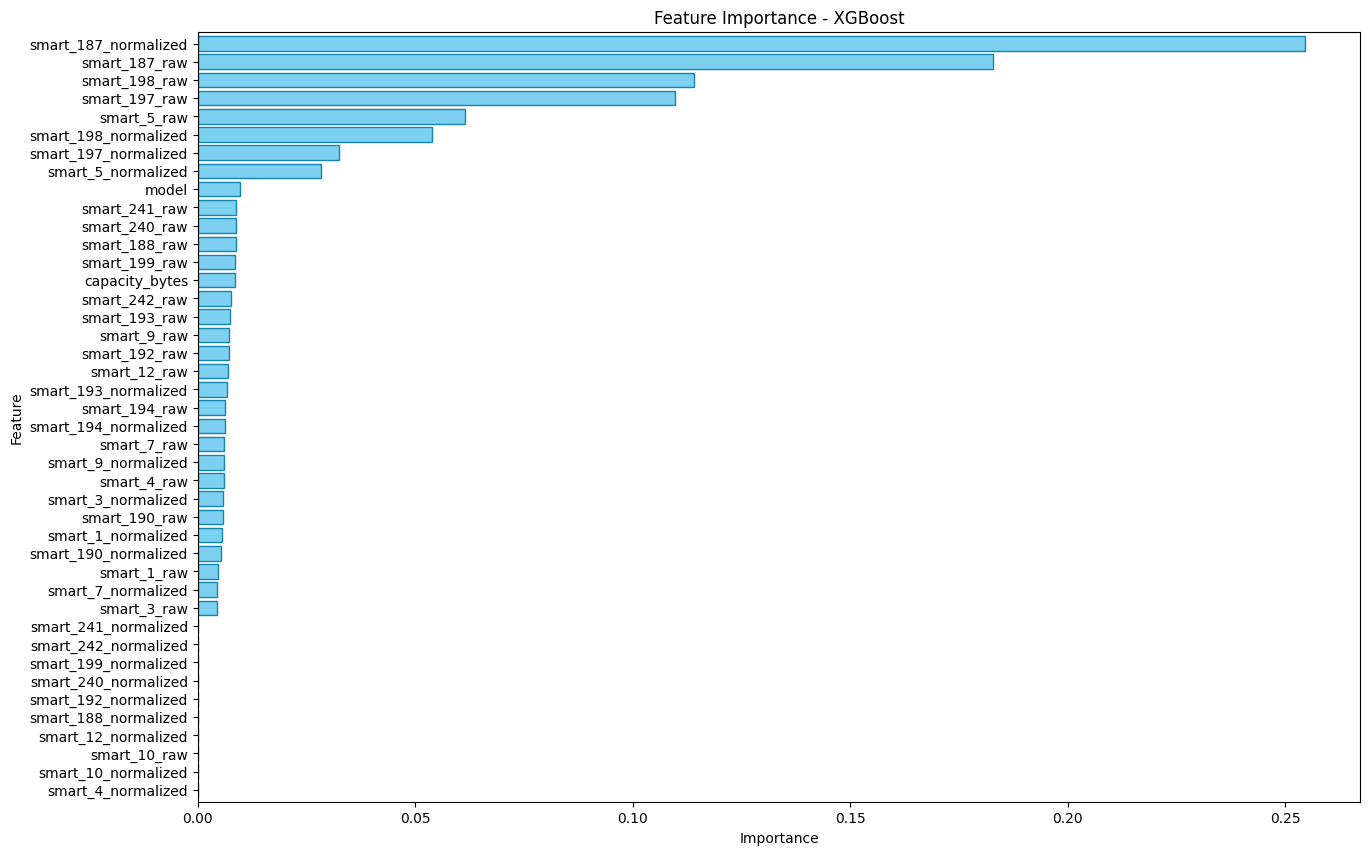

In [8]:
# Display feature importance
plt.figure(figsize=(15,10))

feature_importances_0 = pd.Series(xgb_model_0.feature_importances_, index=X_train_0.columns)
feature_importances_0.sort_values(ascending=True, inplace=True)
fig = feature_importances_0.plot.barh(color=[(0.49, 0.816, 0.941)], edgecolor=[(0.071, 0.522, 0.69)], width=0.8, align='center')

plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance - XGBoost")

print(feature_importances_0)

0.9244921322468739


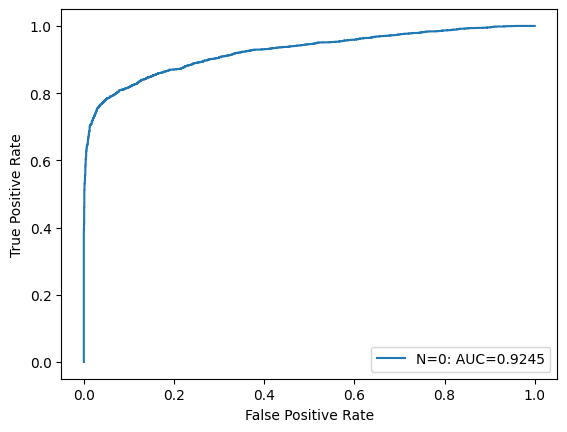

In [9]:
# Calculate AUROC
fpr_0, tpr_0, _ = roc_curve(y_test_0, xgb_model_0.predict_proba(X_test_0)[:,1])
auc_0 = round(roc_auc_score(y_test_0, xgb_model_0.predict_proba(X_test_0)[:,1]), 4)
plt.plot(fpr_0,tpr_0,label="N=0: AUC="+str(auc_0))
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

auroc_score_0 = roc_auc_score(y_true=y_test_0, y_score=xgb_model_0.predict_proba(X_test_0)[:,1])
print(auroc_score_0)

Day minus 1

In [10]:
# Train the XGBoost model
xgb_model_1 = XGBClassifier(objective='binary:logistic', n_estimators=950, max_depth=9, learning_rate=0.0075, subsample=0.791, colsample_bytree=0.7006, random_state=74)
xgb_model_1.fit(X_train_1, y_train_1)

test_predictions_1 = xgb_model_1.predict(X_test_1)
cm = confusion_matrix(y_true=y_test_1, y_pred=test_predictions_1)
print(cm)

# Evaluate the model on test set
test_accuracy_1 = xgb_model_1.score(X_test_1, y_test_1)
print("Test Accuracy:", test_accuracy_1)

[[2482  153]
 [ 685 2035]]
Test Accuracy: 0.8435107376283847


smart_4_normalized      0.000000
smart_10_normalized     0.000000
smart_10_raw            0.000000
smart_12_normalized     0.000000
smart_188_normalized    0.000000
smart_192_normalized    0.000000
smart_240_normalized    0.000000
smart_199_normalized    0.000000
smart_242_normalized    0.000000
smart_241_normalized    0.000000
smart_3_raw             0.004224
smart_1_raw             0.005185
smart_7_normalized      0.005321
smart_190_raw           0.005623
smart_190_normalized    0.005687
smart_194_normalized    0.006041
smart_194_raw           0.006142
smart_9_normalized      0.006175
smart_3_normalized      0.006211
smart_1_normalized      0.006298
smart_4_raw             0.006590
smart_7_raw             0.006662
smart_12_raw            0.007086
smart_193_normalized    0.007110
smart_9_raw             0.007460
smart_188_raw           0.007567
smart_242_raw           0.008046
smart_193_raw           0.008214
smart_199_raw           0.008249
smart_192_raw           0.009035
smart_240_

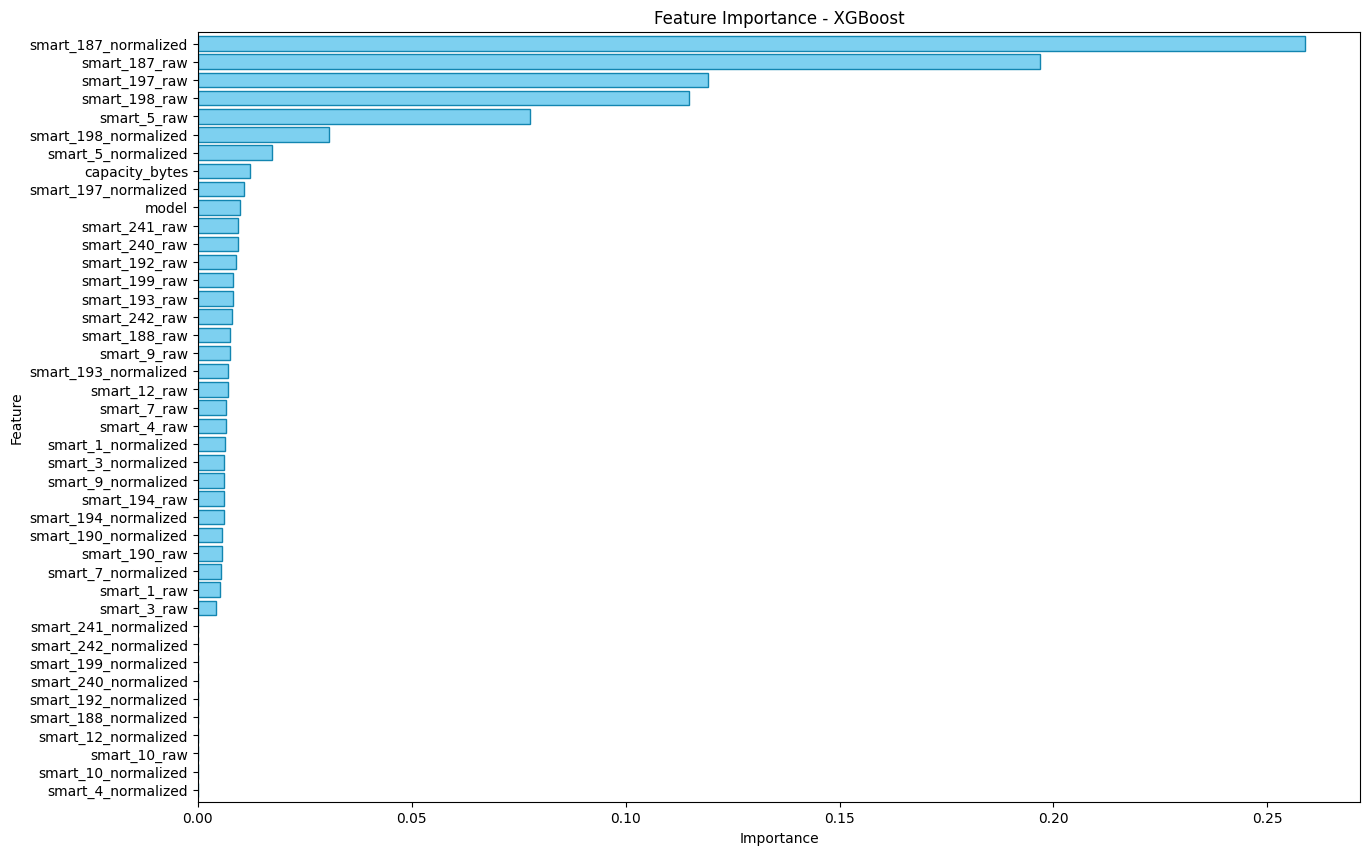

In [11]:
plt.figure(figsize=(15,10))

feature_importances_1 = pd.Series(xgb_model_1.feature_importances_, index=X_train_1.columns)
feature_importances_1.sort_values(ascending=True, inplace=True)
fig = feature_importances_1.plot.barh(color=[(0.49, 0.816, 0.941)], edgecolor=[(0.071, 0.522, 0.69)], width=0.8, align='center')

plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance - XGBoost")

print(feature_importances_1)

0.9082495953789487


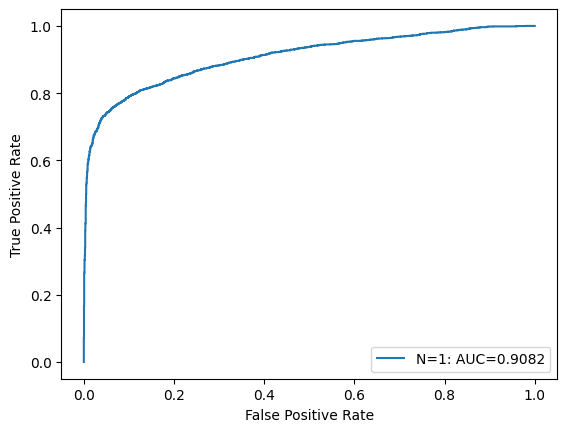

In [12]:
fpr_1, tpr_1, _ = roc_curve(y_test_1, xgb_model_1.predict_proba(X_test_1)[:,1])
auc_1 = round(roc_auc_score(y_test_1, xgb_model_1.predict_proba(X_test_1)[:,1]), 4)
plt.plot(fpr_1,tpr_1,label="N=1: AUC="+str(auc_1))
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

auroc_score_1 = roc_auc_score(y_true=y_test_1, y_score=xgb_model_1.predict_proba(X_test_1)[:,1])
print(auroc_score_1)

Day minus 2

In [13]:
# Train the XGBoost model
xgb_model_2 = XGBClassifier(objective='binary:logistic', n_estimators=950, max_depth=9, learning_rate=0.0075, subsample=0.791, colsample_bytree=0.7006, random_state=74)
xgb_model_2.fit(X_train_2, y_train_2)

test_predictions_2 = xgb_model_2.predict(X_test_2)
cm = confusion_matrix(y_true=y_test_2, y_pred=test_predictions_2)
print(cm)

# Evaluate the model on test set
test_accuracy_2 = xgb_model_2.score(X_test_2, y_test_2)
print("Test Accuracy:", test_accuracy_2)

[[2465  190]
 [ 763 1932]]
Test Accuracy: 0.8218691588785046


smart_4_normalized      0.000000
smart_3_raw             0.000000
smart_10_raw            0.000000
smart_10_normalized     0.000000
smart_188_normalized    0.000000
smart_192_normalized    0.000000
smart_12_normalized     0.000000
smart_198_normalized    0.000000
smart_240_normalized    0.000000
smart_241_normalized    0.000000
smart_199_normalized    0.000000
smart_242_normalized    0.000000
smart_1_raw             0.006156
smart_7_normalized      0.006178
smart_190_raw           0.006920
smart_9_normalized      0.007054
smart_190_normalized    0.007090
smart_194_normalized    0.007182
smart_4_raw             0.007240
smart_3_normalized      0.007458
smart_1_normalized      0.007563
smart_7_raw             0.007911
smart_194_raw           0.008190
smart_193_normalized    0.008336
smart_12_raw            0.008384
smart_188_raw           0.008402
smart_9_raw             0.008980
smart_193_raw           0.009141
smart_192_raw           0.009401
smart_242_raw           0.010098
smart_240_

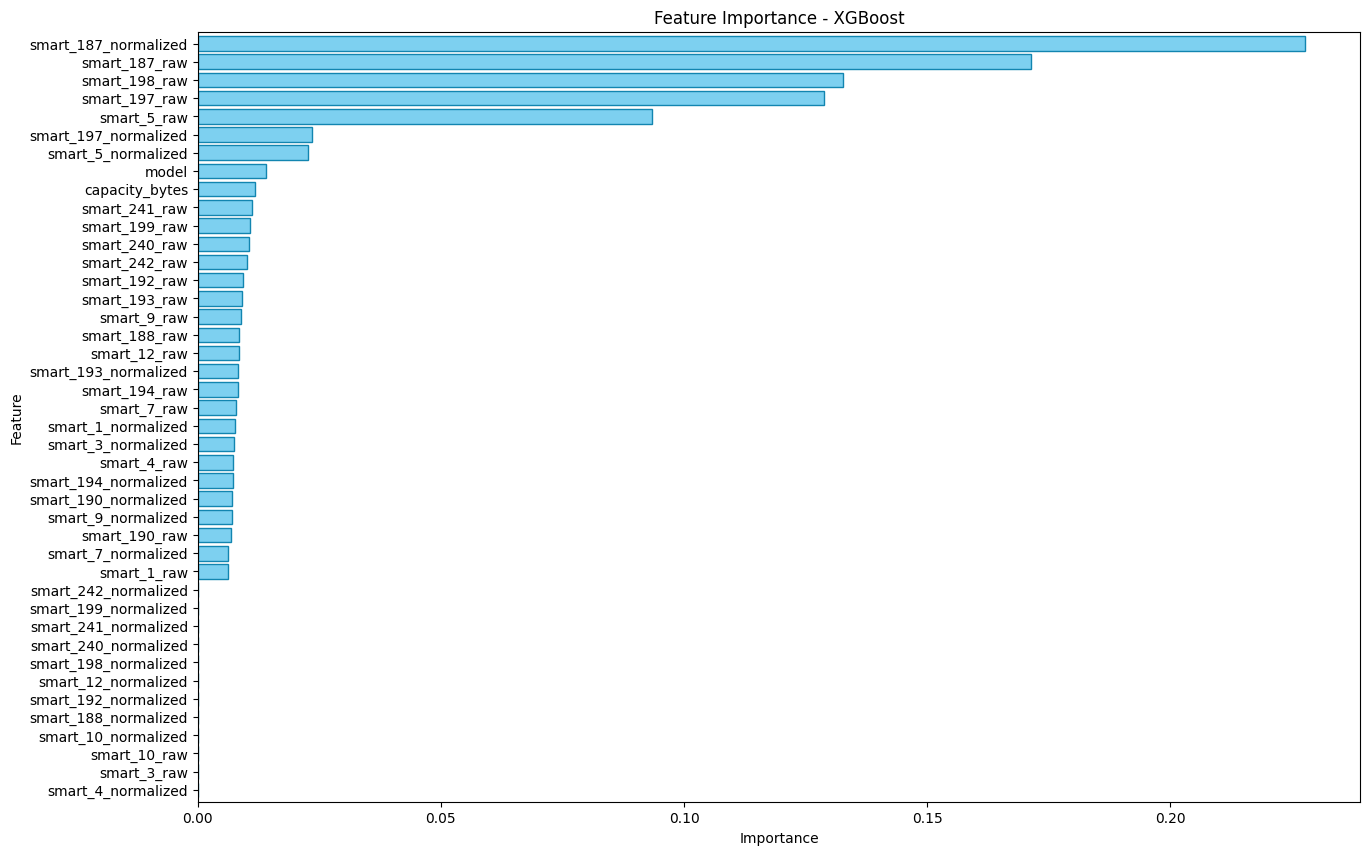

In [14]:
plt.figure(figsize=(15,10))

feature_importances_2 = pd.Series(xgb_model_2.feature_importances_, index=X_train_2.columns)
feature_importances_2.sort_values(ascending=True, inplace=True)
fig = feature_importances_2.plot.barh(color=[(0.49, 0.816, 0.941)], edgecolor=[(0.071, 0.522, 0.69)], width=0.8, align='center')

plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance - XGBoost")

print(feature_importances_2)

0.8984544860573916


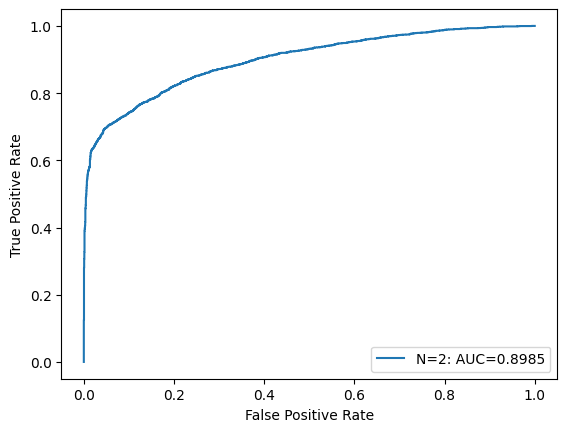

In [15]:
fpr_2, tpr_2, _ = roc_curve(y_test_2, xgb_model_2.predict_proba(X_test_2)[:,1])
auc_2 = round(roc_auc_score(y_test_2, xgb_model_2.predict_proba(X_test_2)[:,1]), 4)
plt.plot(fpr_2,tpr_2,label="N=2: AUC="+str(auc_2))
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

auroc_score_2 = roc_auc_score(y_true=y_test_2, y_score=xgb_model_2.predict_proba(X_test_2)[:,1])
print(auroc_score_2)

Day minus 7

In [16]:
# Train the XGBoost model
xgb_model_7 = XGBClassifier(objective='binary:logistic', n_estimators=950, max_depth=9, learning_rate=0.0075, subsample=0.791, colsample_bytree=0.7006, random_state=74)
xgb_model_7.fit(X_train_7, y_train_7)

test_predictions_7 = xgb_model_7.predict(X_test_7)
cm = confusion_matrix(y_true=y_test_7, y_pred=test_predictions_7)
print(cm)

# Evaluate the model on test set
test_accuracy_7 = xgb_model_7.score(X_test_7, y_test_7)
print("Test Accuracy:", test_accuracy_7)

[[2393  252]
 [ 800 1927]]
Test Accuracy: 0.8041697691734921


smart_3_raw             0.000000
smart_10_normalized     0.000000
smart_10_raw            0.000000
smart_12_normalized     0.000000
smart_188_normalized    0.000000
smart_192_normalized    0.000000
smart_199_normalized    0.000000
smart_198_normalized    0.000000
smart_240_normalized    0.000000
smart_241_normalized    0.000000
smart_242_normalized    0.000000
smart_4_normalized      0.001766
smart_197_normalized    0.002128
smart_7_normalized      0.006907
smart_1_raw             0.007103
smart_1_normalized      0.007768
smart_4_raw             0.008114
smart_7_raw             0.008194
smart_190_raw           0.008441
smart_3_normalized      0.008537
smart_9_normalized      0.008645
smart_190_normalized    0.008735
smart_188_raw           0.009338
smart_194_raw           0.009496
smart_194_normalized    0.009585
smart_193_normalized    0.009806
smart_12_raw            0.009969
smart_242_raw           0.010114
smart_9_raw             0.010150
smart_193_raw           0.010453
smart_192_

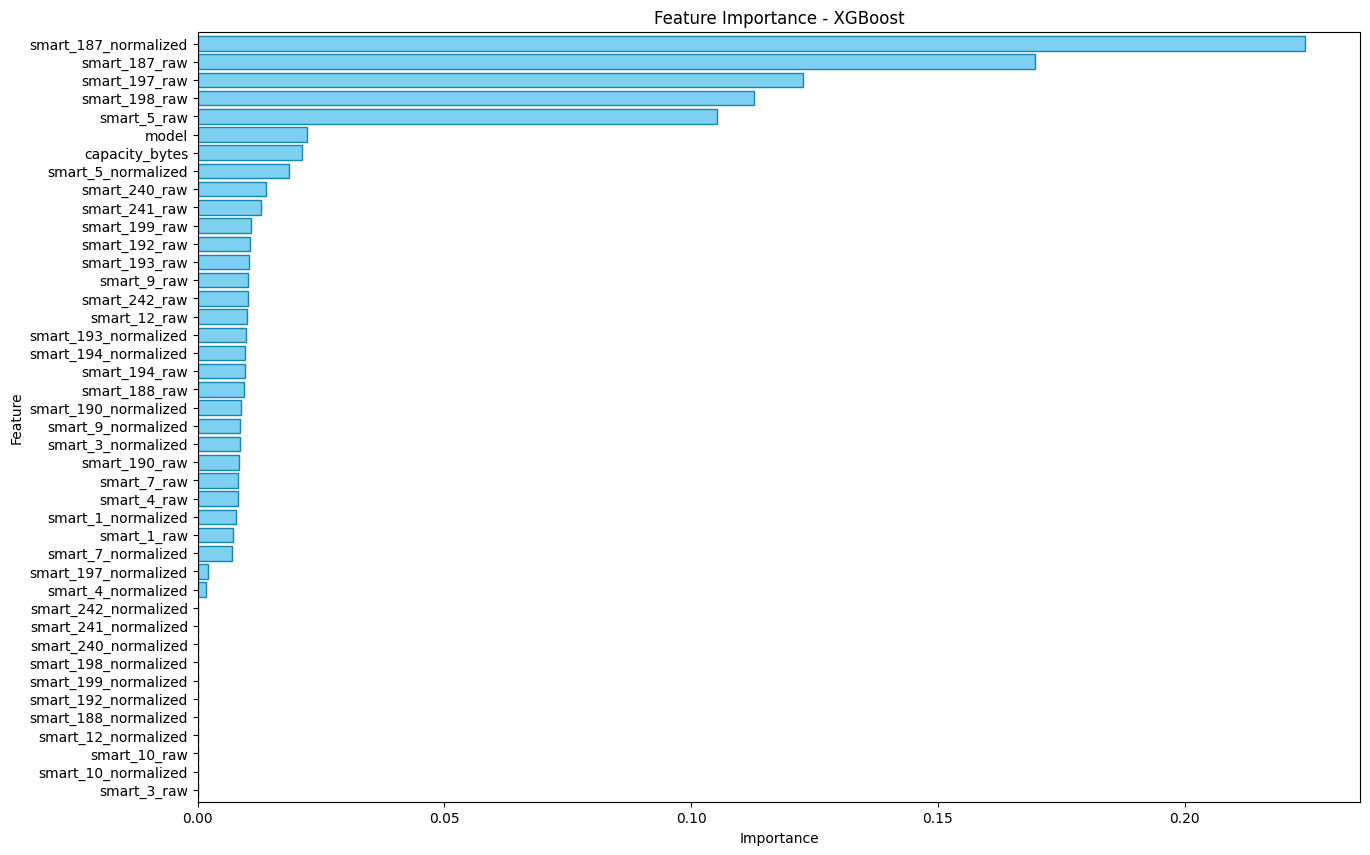

In [17]:
plt.figure(figsize=(15,10))

feature_importances_7 = pd.Series(xgb_model_7.feature_importances_, index=X_train_7.columns)
feature_importances_7.sort_values(ascending=True, inplace=True)
fig = feature_importances_7.plot.barh(color=[(0.49, 0.816, 0.941)], edgecolor=[(0.071, 0.522, 0.69)], width=0.8, align='center')

plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance - XGBoost")

print(feature_importances_7)

0.8781335978588407


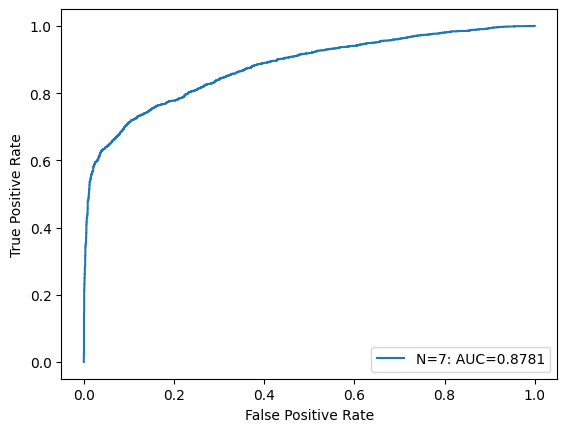

In [18]:
fpr_7, tpr_7, _ = roc_curve(y_test_7, xgb_model_7.predict_proba(X_test_7)[:,1])
auc_7 = round(roc_auc_score(y_test_7, xgb_model_7.predict_proba(X_test_7)[:,1]), 4)
plt.plot(fpr_7,tpr_7,label="N=7: AUC="+str(auc_7))
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

auroc_score_7 = roc_auc_score(y_true=y_test_7, y_score=xgb_model_7.predict_proba(X_test_7)[:,1])
print(auroc_score_7)

Plot ROC curves for each lookahead window

In [19]:
print(auroc_score_0)
print(auroc_score_1)
print(auroc_score_2)
print(auroc_score_7)

0.9244921322468739
0.9082495953789487
0.8984544860573916
0.8781335978588407


In [20]:
from sklearn.model_selection import cross_val_score

cfs_0 = cross_val_score(xgb_model_0, X_test_0, y_test_0, cv=5, scoring='roc_auc')
cfs_1 = cross_val_score(xgb_model_1, X_test_1, y_test_1, cv=5, scoring='roc_auc')
cfs_2 = cross_val_score(xgb_model_2, X_test_2, y_test_2, cv=5, scoring='roc_auc')
cfs_7 = cross_val_score(xgb_model_7, X_test_7, y_test_7, cv=5, scoring='roc_auc')

print(f'N=0: AUROC:{cfs_0.mean()}, STD:{cfs_0.std()}, MAX:{cfs_0.max()}, MIN:{cfs_0.min()}')
print(f'N=1: AUROC:{cfs_1.mean()}, STD:{cfs_1.std()}, MAX:{cfs_1.max()}, MIN:{cfs_1.min()}')
print(f'N=2: AUROC:{cfs_2.mean()}, STD:{cfs_2.std()}, MAX:{cfs_2.max()}, MIN:{cfs_2.min()}')
print(f'N=7: AUROC:{cfs_7.mean()}, STD:{cfs_7.std()}, MAX:{cfs_7.max()}, MIN:{cfs_7.min()}')

N=0: AUROC:0.9161941992047129, STD:0.006588476965088386, MAX:0.9260628465804066, MIN:0.9101245804501444
N=1: AUROC:0.8953726699408417, STD:0.012601123535155133, MAX:0.9176665922535997, MIN:0.8843097722960154
N=2: AUROC:0.8841392129527723, STD:0.008332923646218182, MAX:0.8940669231226133, MIN:0.8752729648613425
N=7: AUROC:0.8652647287388273, STD:0.007060434260246364, MAX:0.874546053658452, MIN:0.8546327648407044


Text(0, 0.5, 'True Positive Rate')

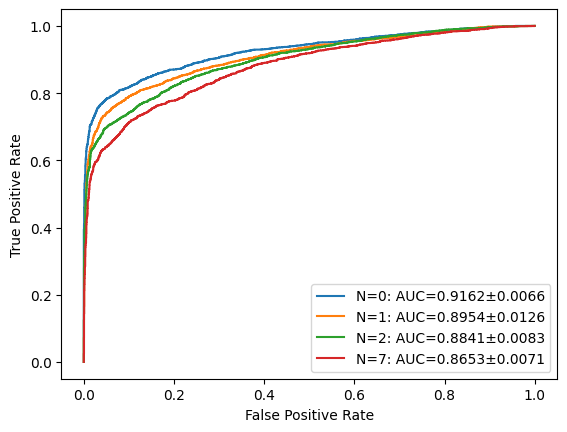

In [21]:
label_0 = f"N=0: AUC={round(cfs_0.mean(), 4)}\u00B1{round(cfs_0.std(), 4)}"
label_1 = f"N=1: AUC={round(cfs_1.mean(), 4)}\u00B1{round(cfs_1.std(), 4)}"
label_2 = f"N=2: AUC={round(cfs_2.mean(), 4):.4f}\u00B1{round(cfs_2.std(), 4)}"
label_7 = f"N=7: AUC={round(cfs_7.mean(), 4)}\u00B1{round(cfs_7.std(), 4)}"

plt.plot(fpr_0,tpr_0,label=label_0)
plt.plot(fpr_1,tpr_1,label=label_1)
plt.plot(fpr_2,tpr_2,label=label_2)
plt.plot(fpr_7,tpr_7,label=label_7)
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [22]:
feature_importances_0.name = 'day_minus_0'
feature_importances_1.name = 'day_minus_1'
feature_importances_2.name = 'day_minus_2'
feature_importances_7.name = 'day_minus_7'
features = pd.concat([feature_importances_0, feature_importances_1, feature_importances_2, feature_importances_7], axis=1)

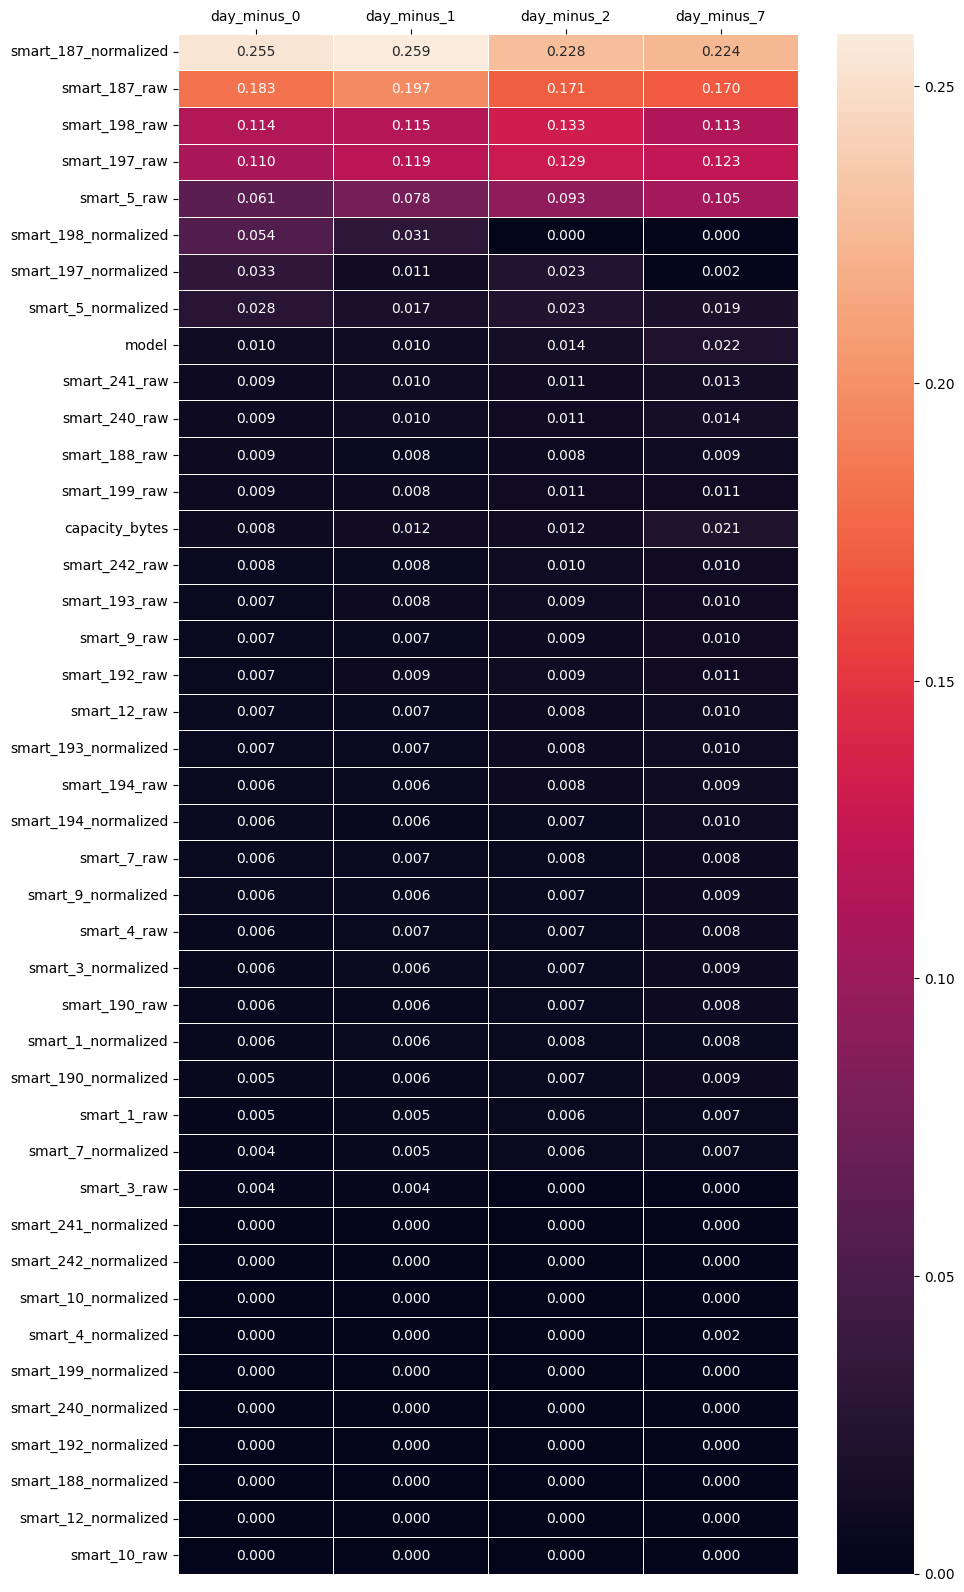

In [23]:
plt.figure(figsize=(10,20))
features.sort_values('day_minus_0', ascending=False, inplace=True)
heatmap_1 = sns.heatmap(data=features, annot=True, linewidth=.5, fmt=".3f")
heatmap_1.xaxis.tick_top()

[Text(0, 0.5, 'Feature'), Text(0.5, 0, 'Importance')]

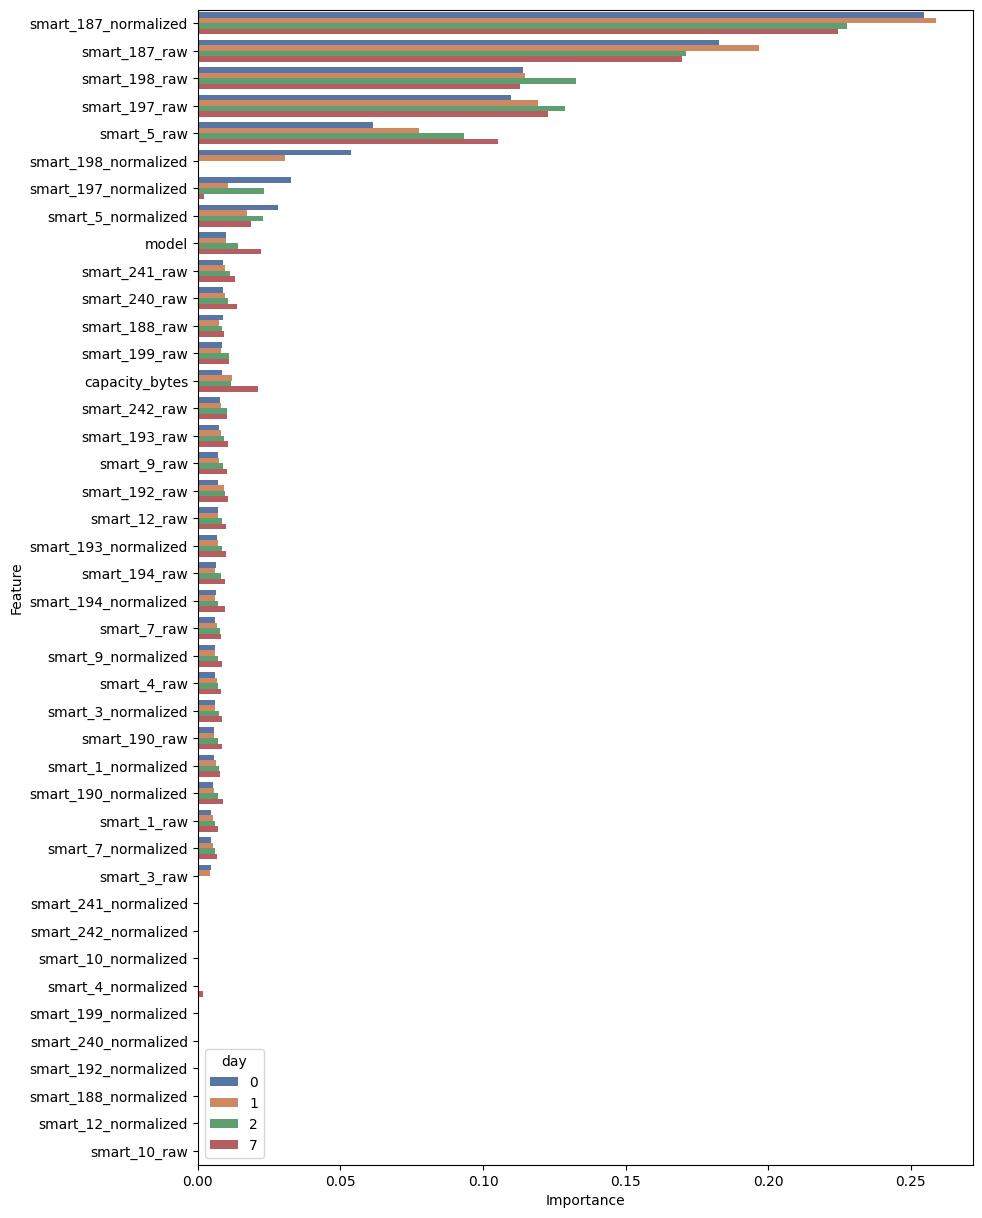

In [24]:
features['feature'] = features.index
wide_to_long = pd.wide_to_long(features, stubnames=['day_minus'], i='feature', j='day', sep="_", suffix=r"(?:\d+|n)").reset_index()

plt.figure(figsize=(10,15))
sns.barplot(data=wide_to_long, y='feature', x='day_minus', hue='day', palette='deep', orient='y').set(ylabel='Feature', xlabel='Importance')

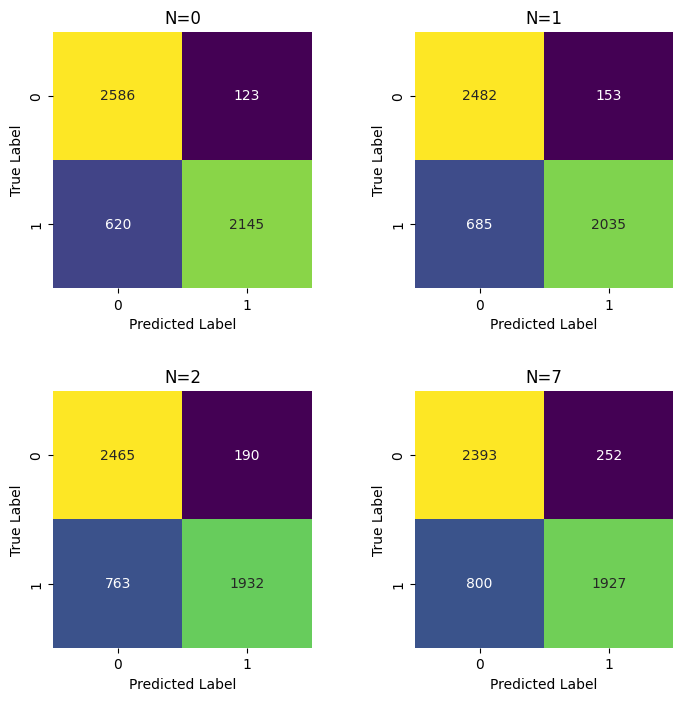

In [25]:
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

cm_0 = confusion_matrix(y_true=y_test_0, y_pred=test_predictions_0)
cm_1 = confusion_matrix(y_true=y_test_1, y_pred=test_predictions_1)
cm_2 = confusion_matrix(y_true=y_test_2, y_pred=test_predictions_2)
cm_7 = confusion_matrix(y_true=y_test_7, y_pred=test_predictions_7)

ax = fig.add_subplot(2, 2, 1)
sns.heatmap(cm_0, annot=True, fmt='d', cmap='viridis', cbar=False, ax=ax)
ax.title.set_text('N=0')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

ax = fig.add_subplot(2, 2, 2)
sns.heatmap(cm_1, annot=True, fmt='d', cmap='viridis', cbar=False, ax=ax)
ax.title.set_text('N=1')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

ax = fig.add_subplot(2, 2, 3)
sns.heatmap(cm_2, annot=True, fmt='d',  cmap='viridis', cbar=False, ax=ax)
ax.title.set_text('N=2')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

ax = fig.add_subplot(2, 2, 4)
sns.heatmap(cm_7, annot=True, fmt='d',  cmap='viridis', cbar=False, ax=ax)
ax.title.set_text('N=7')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

plt.show()

In [26]:
from sklearn.metrics import classification_report

print(classification_report(y_test_0, test_predictions_0))
print(classification_report(y_test_1, test_predictions_1))
print(classification_report(y_test_2, test_predictions_2))
print(classification_report(y_test_7, test_predictions_7))

              precision    recall  f1-score   support

           0       0.81      0.95      0.87      2709
           1       0.95      0.78      0.85      2765

    accuracy                           0.86      5474
   macro avg       0.88      0.87      0.86      5474
weighted avg       0.88      0.86      0.86      5474

              precision    recall  f1-score   support

           0       0.78      0.94      0.86      2635
           1       0.93      0.75      0.83      2720

    accuracy                           0.84      5355
   macro avg       0.86      0.85      0.84      5355
weighted avg       0.86      0.84      0.84      5355

              precision    recall  f1-score   support

           0       0.76      0.93      0.84      2655
           1       0.91      0.72      0.80      2695

    accuracy                           0.82      5350
   macro avg       0.84      0.82      0.82      5350
weighted avg       0.84      0.82      0.82      5350

              preci

In [27]:
TP_0 = cm_0[1][1]
TN_0 = cm_0[0][0]
FP_0 = cm_0[0][1]
FN_0 = cm_0[1][0]

TP_1 = cm_1[1][1]
TN_1 = cm_1[0][0]
FP_1 = cm_1[0][1]
FN_1 = cm_1[1][0]

TP_2 = cm_2[1][1]
TN_2 = cm_2[0][0]
FP_2 = cm_2[0][1]
FN_2 = cm_2[1][0]

TP_7 = cm_7[1][1]
TN_7 = cm_7[0][0]
FP_7 = cm_7[0][1]
FN_7 = cm_7[1][0]

cm_paramaters_0 = {'tp': TP_0, 'tn': TN_0, 'fp': FP_0, 'fn': FN_0, 'day':'0'}
cm_paramaters_1 = {'tp': TP_1, 'tn': TN_1, 'fp': FP_1, 'fn': FN_1, 'day':'1'}
cm_paramaters_2 = {'tp': TP_2, 'tn': TN_2, 'fp': FP_2, 'fn': FN_2, 'day':'2'}
cm_paramaters_7 = {'tp': TP_7, 'tn': TN_7, 'fp': FP_7, 'fn': FN_7, 'day':'7'}

cm_parameters = pd.DataFrame([cm_paramaters_0, cm_paramaters_1, cm_paramaters_2, cm_paramaters_7])